# Библиотеки

In [1]:
from zlib import crc32

import numpy as np
import pandas as pd
import scipy.stats as st

from nltk import lm
from nltk.util import ngrams as nltk_ngrams
from nltk.tag.hmm import HiddenMarkovModelTrainer
from pandas import DataFrame, read_csv
from seaborn import heatmap

# Код генерации выборки

In [2]:
import re
EMAIL_REGEX = re.compile(r"[^@]+@phystech.edu")

def generate_dataset(code):
    rs = np.random.RandomState(code)
    length = rs.randint(low = 25, high = 75)
    proba = rs.uniform()
    x = [(rs.uniform() > 0.5) * 1.0]
    for i in range(length):
        if rs.uniform() < proba:
            x.append(x[-1])
        else:
            x.append(1 - x[-1])
    return np.array(x)

# Генерация выборки для вашей почты

<span style="color:red">
    ВАЖНО!
    Почта, которую укажете ниже и почта с которой Вы отправляете домашнее задание должна совпадать!
    В момент проверки задания алгоритм генерирует выборку на основе почты из анкеты!
</span>

Внимательно проверьте почту для которой выполняется задание!

In [3]:
task = dict()
task['mail'] = input(prompt='Enter your mail: ')
assert EMAIL_REGEX.match(task['mail']), 'Not a mail in the phystech.edu domain'
task['id'] = crc32(task['mail'].encode('utf-8'))
task['data'] = generate_dataset(task['id'])

task

Enter your mail: egorov.sa@phystech.edu


{'mail': 'egorov.sa@phystech.edu',
 'id': 1581189463,
 'data': array([1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.])}

# Работа с выборкой

In [11]:
data = pd.DataFrame(task['data'])

In [12]:
data[0].value_counts()

0.0    28
1.0    19
Name: 0, dtype: int64

In [13]:
data = data.astype(str)

In [22]:
array = data.values.T.reshape(data.values.T.shape[1]).astype(float).astype(int)

In [23]:
from collections import Counter

def ngrams_and_prefix_counts(tokens, n_max):
    # словарь n-грамм и их частот
    ngrams_counts = {}
    # словарь n-граммных префиксов и их частот
    prefix_counts = {}

    n = len(tokens)
    for i in range(n_max):
        ngrams_counts[i + 1] = Counter([tuple(tokens[j : j + i + 1]) for j in range(n - i)])
        prefix_counts[i + 1] = Counter([tuple(tokens[j : j + i] + ['*']) for j in range(n - i)])

    return ngrams_counts, prefix_counts

2-грамма и ее частотная вероятность

In [24]:
def bigram_probas(ngram_counts, prefix_counts):
    p2 = {}
    for w in ngram_counts[2]:
        pre_w = tuple([w[0]] + ['*'])
        p2[u'{1}|{0}'.format(*w)] = ngram_counts[2][w] / prefix_counts[2][pre_w]
    return p2

In [25]:
ngram_counts, prefix_counts = ngrams_and_prefix_counts(list(array), 3)

# Задание

## Вопрос 1
Оценка $p(X_{i+1}= 0|X_{i}=0)$ методом максимального правдоподобия

In [14]:
tokens = data[0].values
vocab = list(data[0].unique())

In [15]:
def make_tag(c):
    return (c, int(float(c)))
supervised = [make_tag(c) for c in data[0]]

Обучим модельку supervised-методом (по ММП)

In [16]:
trainer = HiddenMarkovModelTrainer(range(2), vocab)
tagger = trainer.train_supervised([supervised])

<Axes: >

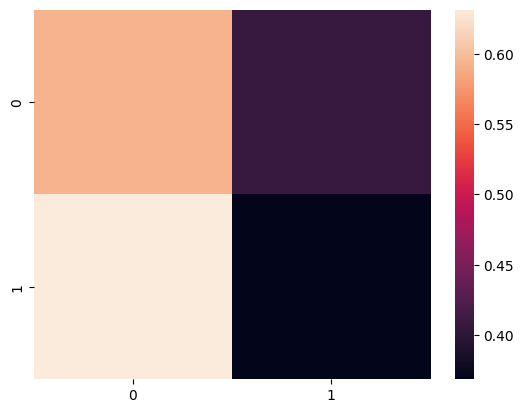

In [17]:
trans_matr = DataFrame(
    data=[
        [tagger._transitions[0].prob(0), tagger._transitions[0].prob(1)],
        [tagger._transitions[1].prob(0), tagger._transitions[1].prob(1)]
    ],
    columns=[0, 1],
    index=[0, 1])
heatmap(trans_matr)

In [18]:
print(f"Оценка p(0|0) = {tagger._transitions[0].prob(0):.2f}")

Оценка p(0|0) = 0.59


## Вопрос 2
Отвергается ли нулевая гипотеза $p(X_{i+1}= 0|X_{i}=0)=0.9$?

Введем статистику $T = \sum^{n - 1}_{i = 1}I[X_{i+1} = 0, X_i = 0]$. Нулевое распределение — биномиальное распределение $Bin(n-1, p)$.

In [26]:
ngram_counts[2]

Counter({(1, 1): 7, (1, 0): 12, (0, 0): 16, (0, 1): 11})

Для нашей последовательности $T = 14$.

In [27]:
import scipy.stats as st
from statsmodels.stats.proportion import proportions_chisquare


T = 14
n = 52
p0 = 0.9
st.binom_test(T, n, p0, alternative='less'), proportions_chisquare(T, n, p0)[1]

<ipython-input-27-78007366b095>:8: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  st.binom_test(T, n, p0, alternative='less'), proportions_chisquare(T, n, p0)[1]


(4.214263498554258e-27, 6.3305005986367e-52)

Полученные $p-value$ меньше 0,05, следовательно, нулевая гипотеза отвергается.

## Вопрос 3
Какова вероятность встретить $X_i=2$ с применением сглаживания Лапласа?

In [19]:
laplace = lm.Laplace(order=1)
laplace.fit([list(nltk_ngrams(tokens, 1))], vocabulary_text=list(set(tokens)))

In [20]:
print(f"Вероятность встретить X_i = 2 с Лапласом: {laplace.score('2'):.2f}")

Вероятность встретить X_i = 2 с Лапласом: 0.02
